In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import xarray as xr
import copy
import os
import sys
sys.path.append(os.path.realpath('../split-data/'))
import return_period_tools as tools
import metrics
import random
import matplotlib as mpl
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
font = {'family' : 'sans-serif','size'   : 6}
mpl.rc('font', **font)
mpl.rcParams['axes.labelsize'] = 6
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6
mpl.rcParams['legend.fontsize'] = 5
mpl.rcParams['lines.markersize'] = 1.5
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams["axes.titlesize"] = 8
mpl.rcParams["grid.color"] = "#dddddd"
mpl.rcParams["grid.linewidth"] = 0.5
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
#Utility function to create a matplotlib figure with cm sizes

def cm2inch(width: float, height: float) -> tuple:
    """Converts figure size from centimeters to inch.
    
    Parameters
    ----------
    width : float
        Width of figure in centimeters
    height : float
        Height of figure in centimeters
    
    Returns
    -------
    Tuple[float, float]
        Tuple containing width and height in inches
    """
    inch = 2.54
    return (width / inch, height / inch)

In [3]:
xr.__version__

'0.16.1'

In [4]:
# Convert flow to   CFS mm -> ft     km^2 -> ft^2    hr->s
conversion_factor = 0.00328084 * 10763910.41671 / 3600 / 24

In [5]:
# Camels attributes with RI information
dataName = '../data/camels_attributes.csv'
# load the data with pandas
pd_attributes = pd.read_csv(dataName, sep=',', index_col='gauge_id')

# Add the basin ID as a 8 element string with a leading zero if neccessary
basin_id_str = []
for a in pd_attributes.index.values:
    basin_id_str.append(str(a).zfill(8))
pd_attributes['basin_id_str'] = basin_id_str

In [6]:
analysis_dict_all={forcing_type:{} for forcing_type in ['nldas', 'daymet']}
peak_flows_dict={forcing_type:{} for forcing_type in ['nldas', 'daymet']}
for forcing_type in ['nldas', 'daymet']:
    print(forcing_type)
    #-------------------------------------------------------------------------------------------------
    frequency_analysis_dict_time_split2 = 'frequency_analysis_dict_time_split2_{}.pkl'.format(forcing_type)
    peak_annual_flows_dict_time_split2 = 'peak_annual_flows_dict_time_split2_{}.pkl'.format(forcing_type)
    frequency_analysis_dict_return_period_split = 'frequency_analysis_dict_return_period_split_{}.pkl'.format(forcing_type)
    peak_annual_flows_dict_return_period_split = 'peak_annual_flows_dict_return_period_split_{}.pkl'.format(forcing_type)
    #-------------------------------------------------------------------------------------------------

    print('    opening ', frequency_analysis_dict_time_split2)
    with open(frequency_analysis_dict_time_split2, 'rb') as fb:
        analysis_dict_all[forcing_type]['time_split2'] = pkl.load(fb)
        
    print('    opening ', peak_annual_flows_dict_time_split2)
    with open(peak_annual_flows_dict_time_split2, 'rb') as fb:
        peak_flows_dict[forcing_type]['time_split2'] = pkl.load(fb)

    print('    opening ', frequency_analysis_dict_return_period_split)
    with open(frequency_analysis_dict_return_period_split, 'rb') as fb:
        analysis_dict_all[forcing_type]['return_period_split'] = pkl.load(fb)
        
    print('    opening ', peak_annual_flows_dict_return_period_split)
    with open(peak_annual_flows_dict_return_period_split, 'rb') as fb:
        peak_flows_dict[forcing_type]['return_period_split'] = pkl.load(fb)

nldas
    opening  frequency_analysis_dict_time_split2_nldas.pkl
    opening  peak_annual_flows_dict_time_split2_nldas.pkl
    opening  frequency_analysis_dict_return_period_split_nldas.pkl
    opening  peak_annual_flows_dict_return_period_split_nldas.pkl
daymet
    opening  frequency_analysis_dict_time_split2_daymet.pkl
    opening  peak_annual_flows_dict_time_split2_daymet.pkl
    opening  frequency_analysis_dict_return_period_split_daymet.pkl
    opening  peak_annual_flows_dict_return_period_split_daymet.pkl


In [7]:
basin_list = list(analysis_dict_all['nldas']['return_period_split'].keys())
print(len(basin_list))

498


In [8]:
#-------------------------------------------------------------------------------------------------
# Set up lists to use in loops
models = ['nwm', 'lstm', 'mc', 'sac']
flows = ['nwm', 'lstm', 'mc', 'sac', 'obs']
models_obs_ri = ['nwm', 'lstm', 'mc', 'sac', 'obs', 'ri']
models_ri = ['nwm', 'lstm', 'mc', 'sac', 'ri']
#-------------------------------------------------------------------------------------------------

all_metrics = ['NSE','MSE','RMSE','KGE','Alpha-NSE','Pearson-r','Beta-NSE','FHV','FMS','FLV','Peak-Timing',
               'beta-abs', 'peakQ', 'peakRI', 'peakT', 'peakQ-perc', 'peakRI-perc', 'peakT-abs']

In [9]:
analysis_dict={forcing_type:{} for forcing_type in ['nldas', 'daymet']}

for forcing_type in ['nldas', 'daymet']:
    analysis_dict[forcing_type]['time_split2'] = {metric:{model:[] for model in models_ri} for metric in all_metrics}
    analysis_dict[forcing_type]['return_period_split'] = {metric:{model:[] for model in models_ri} for metric in all_metrics}

    for ib, basin_0str in enumerate(list(analysis_dict_all[forcing_type]['return_period_split'].keys())):
        for metric in all_metrics:
            for model in models_ri:
                analysis_dict[forcing_type]['return_period_split'][metric][model].extend(analysis_dict_all[forcing_type]['return_period_split'][basin_0str][metric][model])

    for ib, basin_0str in enumerate(list(analysis_dict_all[forcing_type]['time_split2'].keys())):
        for metric in all_metrics:
            for model in models_ri:
                analysis_dict[forcing_type]['time_split2'][metric][model].extend(analysis_dict_all[forcing_type]['time_split2'][basin_0str][metric][model])

In [10]:
ylimz_bar = {'NSE':[0,1], 'MSE':[0,7], 'RMSE':[0,3.5], 'KGE':[0,1], 'Alpha-NSE':[0,1], 'Pearson-r':[0,1], 
         'Beta-NSE':[-0.1,0.1], 'FHV':[-40,10], 'FMS':[-45,0],'FLV':[-60,60], 'Peak-Timing':[0,1],
          'beta-abs':[0,0.25], 'peakQ':[-7500, 0], 'peakRI':[-300,150], 'peakT':[-1,1], 
          'peakQ-perc':[0,0.7], 'peakRI-perc':[0,1], 'peakT-abs':[0,12]}
ylimz_box = {'NSE':[0,1], 'MSE':[0,7], 'RMSE':[0,3.5], 'KGE':[0,1], 'Alpha-NSE':[0,1], 'Pearson-r':[0,1], 
         'Beta-NSE':[-0.1,0.1], 'FHV':[-40,10], 'FMS':[-45,0],'FLV':[-60,60], 'Peak-Timing':[0,1],
          'beta-abs':[0,0.25], 'peakQ':[-7500, 0], 'peakRI':[-300,150], 'peakT':[-1,1], 
          'peakQ-perc':[0,1], 'peakRI-perc':[0,1], 'peakT-abs':[0,12]}
xlimz_freq = {'NSE':[-1,1], 'MSE':[0,1], 'RMSE':[0,0.7], 'KGE':[-1,1], 'Alpha-NSE':[0,1], 'Pearson-r':[0,1], 
         'Beta-NSE':[-0.4,0.1], 'FHV':[-60,60], 'FMS':[0,-60],'FLV':[-25,25], 'Peak-Timing':[-1,1],
          'beta-abs':[0,0.4], 'peakQ':[-20000, 0], 'peakRI':[-300,150], 'peakT':[-1,1], 
          'peakQ-perc':[0,2], 'peakRI-perc':[0,1.3], 'peakT-abs':[0,2.2]}
namz = {'NSE':'Nash–Sutcliffe efficiency', 'MSE':'Mean squared error', 'RMSE':'Root mean squared error', 
        'KGE':'Kling-Gupta efficiency', 'Alpha-NSE':'Alpha-NSE: Flow variance', 'Pearson-r':'Pearson-r', 
         'Beta-NSE':'Beta-NSE: Volume bias', 'FHV':'FHV: Top 2 % peak flow bias', 
         'FMS':'FMS: Bias of FDC midsegment slope','FLV':'FLV: 30 % low flow bias', 
         'Peak-Timing':'Peak-Timing error','beta-abs':'Absolute volume bias', 'peakQ':'Peak flow error', 
         'peakRI':'Peak recurrence interval error', 'peakT':'Timing error of peak flow', 
         'peakQ-perc':'Abs. percent error of peak flow', 'peakRI-perc':'Abs. percent error of recurrence', 
         'peakT-abs':'Absolute timing error of peak flow'}
legend_locz = {'NSE':'upper right', 'MSE':'upper left', 'RMSE':'upper left', 
        'KGE':'upper right', 'Alpha-NSE':'lower right', 'Pearson-r':'lower right', 
         'Beta-NSE':'lower left', 'FHV':'lower left', 'FMS':'lower right','FLV':'upper right', 
         'Peak-Timing':'upper right','beta-abs':'upper right', 'peakQ':'lower left', 
         'peakRI':'lower left', 'peakT':'lower left', 
         'peakQ-perc':'upper left', 'peakRI-perc':'upper left', 'peakT-abs':'upper center'}
colz = {'NSE':2, 'MSE':1, 'RMSE':1, 'KGE':2, 'Alpha-NSE':2, 'Pearson-r':1, 
         'Beta-NSE':1, 'FHV':1, 'FMS':1,'FLV':2, 'Peak-Timing':1,
          'beta-abs':2, 'peakQ':1, 'peakRI':1, 'peakT':1, 
          'peakQ-perc':1, 'peakRI-perc':1, 'peakT-abs':1}

In [11]:
model_label_list = ['LSTM', 'MC-LSTM', 'SAC-SMA', 'NWM*']
model_name_list = ['lstm', 'mc', 'sac', 'nwm']
model_colors = ['b', 'orange', 'red', 'red']
model_style = ['-', '-', '-', '--']
model_name_label_dict = {model_name:model_label for model_name, model_label in \
                         zip(model_name_list,model_label_list)}
model_ri_list = ['ri', 'lstm', 'mc', 'sac', 'nwm']
train_types = ['time_split2','return_period_split']

base_metrics = metrics.get_available_metrics()

In [12]:
plot_metrics = ['NSE','KGE','Alpha-NSE','Pearson-r','Beta-NSE','FHV','FMS','FLV','Peak-Timing']
ppm = {'NSE':'NSE','KGE':'KGE','Alpha-NSE':'Alpha-NSE',
       'Pearson-r':'Pearson-r','Beta-NSE':'Beta-NSE',
       'FHV':'FHV','FMS':'FMS','FLV':'FLV','peakT-abs':'Peak-Timing'}

In [13]:
def set_box_color(bp, color, linestylez='-', linewidthz=2):
    plt.setp(bp['boxes'], color=color, linestyle=linestylez,linewidth=linewidthz)
    plt.setp(bp['whiskers'], color=color, linestyle=linestylez,linewidth=linewidthz)
    plt.setp(bp['caps'], color=color, linestyle=linestylez,linewidth=linewidthz)
    plt.setp(bp['medians'], color=color, linestyle=linestylez,linewidth=linewidthz)

Nash–Sutcliffe efficiency


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


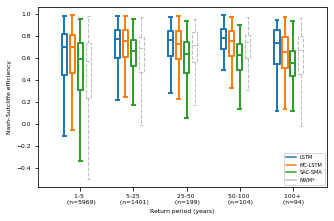

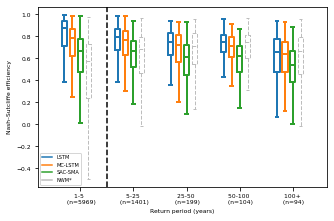

Abs. percent error of peak flow


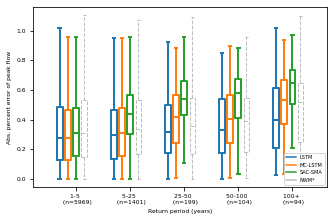

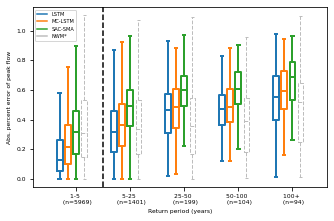

In [14]:
count_missing = {forcing_type:{train_type:{} for train_type in train_types} for forcing_type in ['nldas', 'daymet']}
#for forcing_type in ['daymet']:
for forcing_type in ['nldas']:
    if forcing_type == 'nldas':
        model_label_list = ['LSTM', 'MC-LSTM', 'SAC-SMA', 'NWM*']
        model_name_list = ['lstm', 'mc', 'sac', 'nwm']
        model_ri_list = ['ri', 'lstm', 'mc', 'sac', 'nwm']
        flows = ['lstm', 'mc', 'sac', 'nwm', 'obs']
    if forcing_type == 'daymet':
        model_label_list = ['LSTM', 'MC-LSTM', 'SAC-SMA']
        model_name_list = ['lstm', 'mc', 'sac']
        model_ri_list = ['ri', 'lstm', 'mc', 'sac']
        flows = ['lstm', 'mc', 'sac', 'obs']
    
    model_name_label_dict = {model_name:model_label for model_name, model_label in \
                             zip(model_name_list,model_label_list)}
    train_types = ['time_split2','return_period_split']
    text_locs = {'NSE':[[-0.55, 0.9],[0.6, 0.9]], 'peakQ-perc':[[-0.55, 0.55],[0.6, 0.55]]}

    ri_list = {}
    ri_bins = {}
    
    #for metric in all_metrics:
    for metric in  ['NSE', 'peakQ-perc']:
        print(namz[metric])
        if True:
            bin_max=[5, 25,50,100,1000000000]
            bin_names=['1-5 \n (n=5969)', '5-25 \n (n=1401)','25-50 \n (n=199)','50-100 \n (n=104)','100+ \n (n=94)']
        else:
            bin_max=[5,1000000000]
            bin_names=['1-5 \n (n=5969)', '5+ \n (n=1798)']
            
        ri_list[metric] = {train_type:{model_label:{bin_name:[] for bin_name in bin_names} for \
                               model_label in model_label_list} for train_type in train_types}
        ri_bins[metric] = {train_type:{model_label:{bin_name:0 for bin_name in bin_names} for \
                               model_label in model_label_list} for train_type in train_types}
        for train_type in train_types:
            ri_bins[metric][train_type]['count'] = {bin_name:0 for bin_name in bin_names}

        for split in ['time_split2','return_period_split']:
            count_missing[forcing_type][split][metric] = {model_ri:0 for model_ri in model_ri_list}
            for i, ri in enumerate(analysis_dict[forcing_type][split][metric]['ri']):
                if analysis_dict[forcing_type][split][metric]['ri'][i] is None:
                    continue

                skip_this=False
                for icheck in model_ri_list:
                    if analysis_dict[forcing_type][split][metric][icheck][i] is None:
                        skip_this=True
                        count_missing[forcing_type][split][metric][icheck]+=1
                    if np.isinf(analysis_dict[forcing_type][split][metric][icheck][i]):
                        skip_this=True
                        count_missing[forcing_type][split][metric][icheck]+=1
                    if isinstance(analysis_dict[forcing_type][split][metric][icheck][i], str):
                        skip_this=True
                        count_missing[forcing_type][split][metric][icheck]+=1
                    if analysis_dict[forcing_type][split][metric][icheck][i] != \
                            analysis_dict[forcing_type][split][metric][icheck][i]:
                        skip_this=True
                        count_missing[forcing_type][split][metric][icheck]+=1

                if skip_this:
                    continue
                    skip_this=False

                for maxv,bin_name in zip(bin_max, bin_names):
                    if ri<maxv:
                        ri_bins[metric][split]['count'][bin_name]+=1
                        for model_name, model_label in zip(model_name_list, model_label_list):
                            ri_list[metric][split][model_label][bin_name].append( \
                                  analysis_dict[forcing_type][split][metric][model_name][i])
                        break



        for split in ['time_split2','return_period_split']:
            fig = plt.figure(figsize=cm2inch(12,8))
            plt.ylabel(namz[metric])
            plt.xlabel('Return period (years)')
            if split == 'return_period_split':
                plt.axvline(x=0.5, color='k', linestyle='--')
            x = np.arange(len(list(bin_names)))  # the label locations
            width = 0.15  # the width of the bars
            data_to_plot = [ri_list[metric][split]['LSTM'][bin_name] for bin_name in bin_names]
            bp_lstm = plt.boxplot(data_to_plot, positions=x - 2*width, sym='', widths=0.1)
            data_to_plot = [ri_list[metric][split]['MC-LSTM'][bin_name] for bin_name in bin_names]
            bp_mc = plt.boxplot(data_to_plot, positions=x - width, sym='', widths=0.1)
            data_to_plot = [ri_list[metric][split]['SAC-SMA'][bin_name] for bin_name in bin_names]
            bp_sac = plt.boxplot(data_to_plot, positions=x, sym='', widths=0.1)
            data_to_plot = [ri_list[metric][split]['NWM*'][bin_name] for bin_name in bin_names]
            bp_nwm = plt.boxplot(data_to_plot, positions=x + width, sym='', widths=0.1)
            set_box_color(bp_lstm, '#1f77b4') # colors are from http://colorbrewer2.org/
            set_box_color(bp_mc, '#ff7f0e')
            set_box_color(bp_sac, '#2ca02c') # colors are from http://colorbrewer2.org/
            set_box_color(bp_nwm, '#bdbdbd', '--', linewidthz=1)

            # draw temporary red and blue lines and use them to create a legend
            plt.plot([], c='#1f77b4', label='LSTM')
            plt.plot([], c='#ff7f0e', label='MC-LSTM')
            plt.plot([], c='#2ca02c', label='SAC-SMA')
            plt.plot([], c='#bdbdbd', label='NWM*')
            plt.legend()

            plt.xticks(range(0, len(bin_names)), bin_names)
            plt.tight_layout()

            fig.tight_layout(pad=1.0)
            plt.show()
            fig.savefig('../figs/boxxs{}_{}_fixed.pdf'.format(metric, split), dpi=600)
            fig.savefig('../figs/boxxs{}_{}_fixed.png'.format(metric, split), dpi=600)
            plt.close()
        

/home/jmframe/programs/anaconda3/envs/mc-paper/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


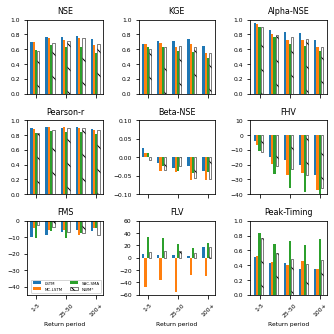

/home/jmframe/programs/anaconda3/envs/mc-paper/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator


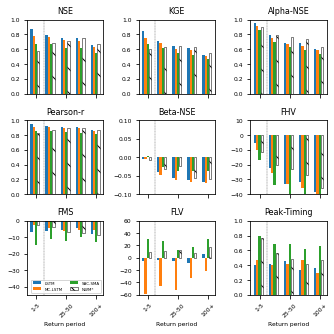

In [15]:
count_missing = {forcing_type:{train_type:{} for train_type in train_types} for forcing_type in ['nldas', 'daymet']}

for forcing_type in ['nldas']:
    
    if forcing_type == 'nldas':
        model_label_list = ['LSTM', 'MC-LSTM', 'SAC-SMA', 'NWM*']
        models = models = ['lstm', 'mc', 'sac', 'nwm']
        flows = ['lstm', 'mc', 'sac', 'nwm', 'obs']
    if forcing_type == 'daymet':
        model_label_list = ['LSTM', 'MC-LSTM', 'SAC-SMA']
        models = models = ['lstm', 'mc', 'sac']
        flows = ['lstm', 'mc', 'sac', 'obs']


    # Big tables for each training type

    for train_type in train_types:

        fig = plt.figure(figsize=cm2inch(12,12))

        ri_list = {metric:{} for metric in all_metrics}
        ri_bins = {metric:{} for metric in all_metrics}
        for imetric, metric in enumerate(plot_metrics):
            bin_max=[5, 25,50,100,1000000000]
            bin_names=['1-5', '5-25','25-50','50-100','100+']
            ri_list[metric][train_type] = {model_label:{bin_name:[] for bin_name in bin_names} for \
                                           model_label in model_label_list}
            ri_bins[metric][train_type] = {model_label:{bin_name:[] for bin_name in bin_names} for \
                                           model_label in model_label_list}

            ri_bins[metric][train_type]['count'] = {bin_name:0 for bin_name in bin_names}

            count_missing[forcing_type][train_type][metric] = {model_ri:0 for model_ri in model_ri_list}
            for i, ri in enumerate(analysis_dict[forcing_type][train_type][metric]['ri']):
                if analysis_dict[forcing_type][train_type][metric]['ri'][i] is None:
                    continue

                skip_this=False
                for icheck in model_ri_list:
                    if analysis_dict[forcing_type][train_type][metric][icheck][i] is None:
                        skip_this=True
                        count_missing[forcing_type][train_type][metric][icheck]+=1
                    if np.isinf(analysis_dict[forcing_type][train_type][metric][icheck][i]):
                        skip_this=True
                        count_missing[forcing_type][train_type][metric][icheck]+=1
                    if isinstance(analysis_dict[forcing_type][train_type][metric][icheck][i], str):
                        skip_this=True
                        count_missing[forcing_type][train_type][metric][icheck]+=1
                    if analysis_dict[forcing_type][train_type][metric][icheck][i] != \
                                         analysis_dict[forcing_type][train_type][metric][icheck][i]:
                        skip_this=True
                        count_missing[forcing_type][train_type][metric][icheck]+=1

                if skip_this:
                    continue
                    skip_this=False

                for maxv,bin_name in zip(bin_max, bin_names):
                    if ri<maxv:
                        ri_bins[metric][train_type]['count'][bin_name]+=1
                        for model_name, model_label in zip(model_name_list, model_label_list):
                            ri_list[metric][train_type][model_label][bin_name].append( \
                                                        analysis_dict[forcing_type][train_type][metric][model_name][i])
                        break


            for maxv,bin_name in zip(bin_max, bin_names):
                if ri_bins[metric][train_type]['count'][bin_name] < 1:
                    continue
                for model_label in model_label_list:
                    if metric in ['Peak-Timing', 'peakT-abs']:
                        ri_bins[metric][train_type][model_label][bin_name] = np.nanmean( \
                                                    ri_list[metric][train_type][model_label][bin_name])
                    else:
                        ri_bins[metric][train_type][model_label][bin_name] = np.nanmedian( \
                                                    ri_list[metric][train_type][model_label][bin_name])

            ax = fig.add_subplot(3, 3, imetric+1)    

    #        pd.DataFrame(ri_bins[metric][train_type])[model_label_list].plot.bar(ax=ax)
            plt_df = pd.DataFrame(ri_bins[metric][train_type])[model_label_list]
            x = np.arange(len(list(plt_df.index.values)))  # the label locations
            width = 0.15  # the width of the bars
            bar1 = ax.bar(x - 2*width, plt_df.loc[:,'LSTM'], width, label='LSTM')
            bar2 = ax.bar(x - width, plt_df.loc[:,'MC-LSTM'], width, label='MC-LSTM')
            bar3 = ax.bar(x, plt_df.loc[:,'SAC-SMA'], width, label='SAC-SMA')
            if forcing_type == 'nldas':
                bar4 = ax.bar(x + width, plt_df.loc[:,'NWM*'], width, label='NWM*', 
                              hatch="\\", color='white', edgecolor='black', linewidth=0.5)
                
            if imetric+1 in [7,8,9]:
                # It is only showing three labels. Probably because of space or something. 
                # So have to hack the labels, cause it tries to show only items 1-3 in the list of 5
                x_tix_labz = ['5-25', '1-5','25-50','100+', '50-100'] # I don't know why, but this works...
                ax.set_xticklabels(x_tix_labz, rotation = 45)
                ax.set_xlabel("Return period")
            else:
                ax.set_xticklabels([])

            ax.set_title(metric)
            ax.set_ylim(ylimz_bar[metric])
            if metric =='FMS':
                ax.legend(fontsize=4, ncol=2, loc='lower right')
    #         else:
    #             ax.get_legend().remove()

            if train_type == "return_period_split":
                ax.axvline(x=0.5, color='k', linestyle='--', lw=0.3)

        fig.tight_layout(pad=1)
        fig.savefig('../figs/bars_{}_training_{}.pdf'.format(train_type, forcing_type), dpi=600)
        fig.savefig('../figs/bars_{}_training_{}.png'.format(train_type, forcing_type), dpi=600)
        plt.show()
        plt.close()

In [16]:

with open('st1_dict.pkl', 'rb') as fb:
    st1_dict = pkl.load(fb)
with open('st2_dict.pkl', 'rb') as fb:
    st2_dict = pkl.load(fb)
with open('rps_dict.pkl', 'rb') as fb:
    rps_dict = pkl.load(fb)

In [17]:
labelz={'nwm':'NWM*', 'lstm':'LSTM', 'mc':'MC-LSTM','sac':'SAC-SMA', 'obs':'Observed'}
forcingz={'nldas':'NLDAS', 'daymet':'Daymet'}

In [18]:
basin_list_int = [int(i) for i in basin_list]
with open("531_basin_list.txt", "r") as f:
    basin_list_531 = pd.read_csv(f, header=None)
basin_list_531_int = [basin_list_531.iloc[i].values[0] for i in range(basin_list_531.shape[0])]

NSE, LSTM - MC-LSTM


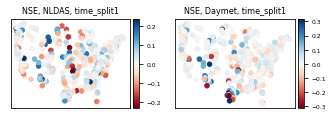

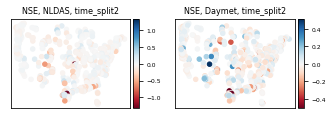

MSE, LSTM - MC-LSTM


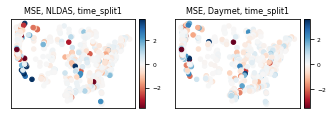

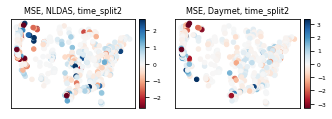

RMSE, LSTM - MC-LSTM


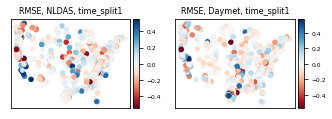

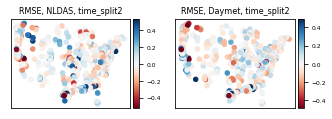

KGE, LSTM - MC-LSTM


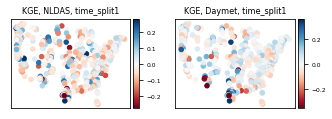

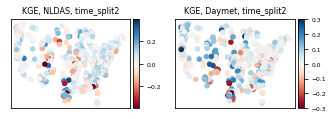

Alpha-NSE, LSTM - MC-LSTM


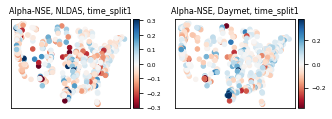

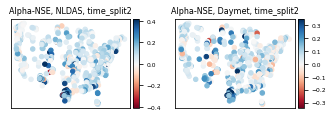

Pearson-r, LSTM - MC-LSTM


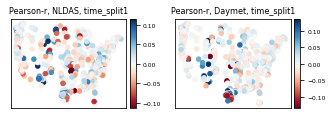

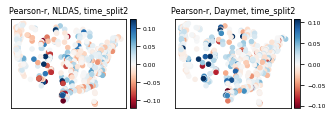

Beta-NSE, LSTM - MC-LSTM


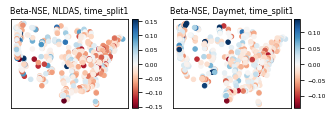

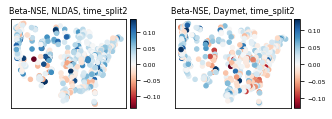

FHV, LSTM - MC-LSTM


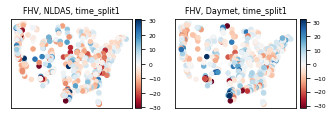

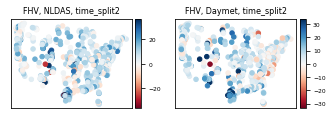

FMS, LSTM - MC-LSTM


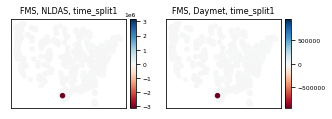

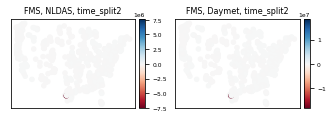

FLV, LSTM - MC-LSTM


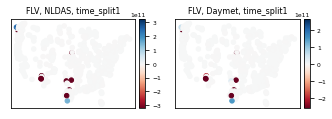

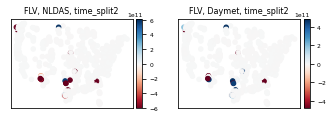

Peak-Timing, LSTM - MC-LSTM


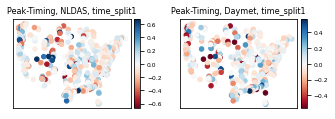

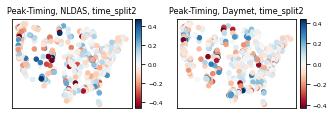

In [19]:
time_splitz = ['time_split1','time_split2']
forcing_products = ['nldas', 'daymet']
for metric in list(st1_dict['nldas'].keys()):
    
    print(metric+", LSTM - MC-LSTM")

    plot_here=1

    for tsplt in time_splitz:

        if tsplt == 'time_split1':
            fig = plt.figure(figsize=cm2inch(12,8))
            plot_dict = st1_dict
        if tsplt == 'time_split2':
            fig = plt.figure(figsize=cm2inch(12,8))
            plot_dict = st2_dict


        for forcing_type in forcing_products:

            plot_this = list(np.array(plot_dict[forcing_type][metric]['lstm']) - \
                             np.array(plot_dict[forcing_type][metric]['mc']))

            ax = fig.add_subplot(2, 2, plot_here)

            im = ax.scatter(pd_attributes.loc[basin_list_531_int, 'gauge_lon'].values, 
                             pd_attributes.loc[basin_list_531_int, 'gauge_lat'].values,
                            c=plot_this,
                            s=20,
                            cmap='RdBu',
                            vmin=-np.std(plot_this)*3, 
                            vmax=np.std(plot_this)*3)
            ax.set_title(metric+', '+str(forcingz[forcing_type])+', '+tsplt)

    #        ax.set_xlabels([])
            ax.set_xticks(ticks=[])
            ax.set_yticks(ticks=[])

            clims = im.get_clim()


            # colorbar
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical')

            plot_here+=1
        plt.tight_layout()
        plt.show()
        plt.close()

In [20]:
len(plot_dict[forcing_type][metric]['lstm'])

531

In [21]:
len(plot_this)

531

In [22]:
pd_attributes.loc[basin_list_int, 'gauge_lon'].values.shape

(498,)

In [23]:
time_splitz = ['time_split1','time_split2']
forcing_products = ['nldas', 'daymet']
for metric in list(st1_dict['nldas'].keys()):
    
    plot_here=1

    for tsplt in time_splitz:

        for forcing_type in forcing_products:

            lstmdata=np.array(plot_dict[forcing_type][metric]['lstm'])
            mclstmdata=np.array(plot_dict[forcing_type][metric]['mc'])
            sacdata=np.array(plot_dict[forcing_type][metric]['mc'])
            
            df = pd.DataFrame(index=basin_list_531_int, 
                         data={'lstm':lstmdata, 'mc':mclstmdata,'sac':sacdata})
            
            df.to_csv(f"{forcing_type}_{tsplt}_{metric}.csv")
